<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>

---

## Goal of afternoon session

The goal of this session is to

> Excercise 1: Write your own convolutional layer from scratch.

> Excercise 2: Add batch normalisation and dropout to the `LeNet5` architecture shown in this morning's lecture, and train it to classify `FashionMNIST`.

> Excercise 3: Perform data augmentation and understand its effects.

> Excercise 4 (optional extension): interpret what the network has learned using the techniques from this morning's lecture.

In [2]:
import requests
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Excercise 1: Write your own convolutional layer from scratch

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/conv-definition.png" width="90%"/>

Given the image below, and **without using PyTorch**:
1) define two filters: a horizontal edge detector and a vertical edge detector ([see here for help on the filter weights](https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm))
2) convolve these two filters with the image
3) plot the convolved output images
4) check your function matches `torch.nn.functional.conv2d`

(256, 256)


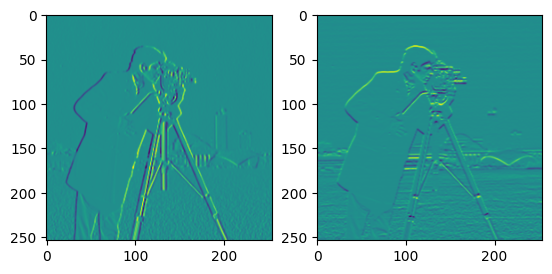

In [7]:
response = requests.get("https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/camera.tif")
x = np.array(Image.open(BytesIO(response.content)), dtype=np.float32)
print(x.shape)

# TODO: define edge detector filters
w_h = np.array([[-1,0,1],
                [-2,0,2],
                [-1,0,1]], dtype=np.float32)
w_v = np.array([[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]], dtype=np.float32)


def conv2d(x, w):
    """2D convolution.
    x: Input image of shape (height, width)
    w: Filter/kernel of shape (filter_height, filter_width)
    returns h: Output image
    """
    # TODO: define conv2d function
    x_h, x_w = x.shape
    w_h, w_w = w.shape

    h_h, h_w = x_h-w_h+1, x_w-w_w+1

    h = np.zeros((h_h, h_w))

    for i in range(h_h):
      for j in range(h_w):
        h[i][j] = np.sum(x[i:i+w_h,j:j+w_w]*w)


    return h


# TODO: plot the convolved output images
output1 = conv2d(x, w_h)
output2 = conv2d(x, w_v)

plt.subplot(121)
plt.imshow(output1)
plt.subplot(122)
plt.imshow(output2)


# TODO: check your function matches `torch.nn.functional.conv2d`


In [15]:
output_torch1 = torch.nn.functional.conv2d(input=torch.from_numpy(x).unsqueeze(0), weight=torch.from_numpy(w_h).unsqueeze(0).unsqueeze(0))
print(np.allclose(output_torch1, output1))

True


In [16]:
w_h.shape, x.shape

((3, 3), (256, 256))

# Excercise 2: Add batch normalisation and dropout to the `LeNet5` architecture shown in this morning's lecture, and train it to classify `FashionMNIST`

<img src="https://benmoseley.blog/uploads/teaching/2024-ESE-DL/images/lenet5.png" width="100%"/>

In [ ]:
# download the FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])
train_dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./', train=False, download=True, transform=transform)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# plot some example images
print(f"{len(train_dataset)} images in training dataset")
print(f"{len(test_dataset)} images in test dataset")
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(classes[train_dataset[i][1]])
    plt.imshow(train_dataset[i][0][0], cmap="grey")
plt.show()

1. First, train the same LeNet5 shown in this morning's lecture to classify the FashionMNIST dataset. Use the same hyperparameters (batch size, optimizer, learning rate etc) as the lecture.
2. Then, add batch normalisation and dropout after each convolutional layer. Retrain the network, and compare performance with the standard LeNet5.
3. What other changes you could make to the architecture / hyperparameters to improve performance?

In [ ]:
# TODO: train the same LeNet5 shown in this morning's lecture to classify the FashionMNIST dataset.
# Use the same hyperparameters (batch size, optimizer, learning rate etc) as the lecture.
class LeNet5(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.c1 = nn.Conv2d(1, 6, 5, 1, padding=2) # output: (28+2*2-5)/1+1 = 28
    self.s2 = nn.MaxPool2d(2,2) # subsampling output: 28/2 = 14
    self.c3 = nn.Conv2d(6, 16, 5, 1) # output: (14-5)/1+1 = 10
    self.s4 = nn.MaxPool2d(2, 2) # output: 5
    self.l5 = nn.Linear(16*5*5, 10)
    self.sofmax = nn.LogSoftmax(dim=1) # dim: (batch, class)
    self.act = nn.ReLU()
  def forward(self, x):
    x = self.act(self.c1(x))
    x  = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = self.softmax(self.l5(x))
    return x


def train(model, optimizer, criterion, train_loader, epochs=1):
  model.train() # set model to train mode so the weights will be updated
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad() # reset optimizer info
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step() # perform one step of gradient descent
      if batch_idx%100==0:
        print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))


def evaluate(model, test_loader):
  model.eval()
  preds = []
  targets = []
  for X, y in test_loader:
    with torch.no_grad(): # deactivates autograd engine
      logp = model(X)
      pred = logp.argmax(dim=1)
      preds.append(pred)
      targets.append(target)
  preds = torch.concat(preds)
  targets = torch.concat(targets)
  correct =



model = LeNet5()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()
# TODO: Add batch normalisation and dropout after each convolutional layer.
# Retrain the network, and compare performance with the standard LeNet5.


# Excercise 3: Perform data augmentation and understand its effects

Using data augmentation can help improve the accuracy of the model and reduce the likelihood of overfitting.

We can easily perform data augmentations by using PyTorch **[transforms](https://pytorch.org/vision/stable/transforms.html#v1-api-reference)** in our training `Dataset` class.

Tasks:
1. Add a transform to `train_dataset` which randomly rotates training images by 10 degrees below ([hint](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html#torchvision.transforms.RandomRotation)), and plot some images to check the rotation is being applied
2. Retrain your models with this transformation. What differences do you observe?
3. Try adding other transformations too (e.g. random cropping, flipping, and gaussian blur)

In [ ]:
# TODO: Add a transform to `train_dataset` which randomly rotates training images by 10 degrees below,
# and plot some images to check the rotation is being applied


# TODO: Retrain your models with this transformation. What differences do you observe?


# TODO: Try adding other transformations too (e.g. random cropping, flipping, and gaussian blur)


# Excercise 4 (optional extension): interpret what the network has learned using the techniques from this morning's lecture

Select a test image, and then plot 1) the feature maps (outputs) of the first convolutional layer and 2) the saliency of the image to its class prediction.

In [ ]:
# TODO: Select a test image, and then plot
# 1) the feature maps (outputs) of the first convolutional layer and
# 2) the saliency of the image to its class prediction

